In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control
from numpy import sin, cos, tan, pi
from control import TransferFunction as TF

In [2]:
plt.rcParams['font.size'] = 14

In [3]:
import py_block_diagram

In [4]:
import importlib

In [5]:
importlib.reload(py_block_diagram)

<module 'py_block_diagram' from '/home/ryanwkrauss/git/py_block_diagram/py_block_diagram/__init__.py'>

In [6]:
import py_block_diagram as pybd

## Test Case 1: Simple Feedback Loop

- the feedback loop is called out explicitly

In [7]:
U = pybd.step_input("$U(s)$")

In [8]:
sum1 = pybd.summing_junction(U,radius=0.35,draw_feedback_loop=False)

In [9]:
U.place_absolute(0,0)

In [10]:
sum1.place_relative(U,"right")

In [11]:
D = pybd.PD_controller(3, 0.1, sum1, "$D(s)$")

In [12]:
D.place_relative(sum1, "right",3.5)

In [13]:
i2c = pybd.i2c_read_block('m_ino')

In [14]:
i2c.place_relative(D,"below", xshift=4)

In [15]:
i2c.label

'i$^2$c'

In [16]:
sum1.set_input2(i2c)

In [17]:
sat = pybd.saturation_block(input_block=D)

In [18]:
sat.place_relative(D,"right",5)

In [19]:
spi = pybd.spi_send_block("h_spi")
spi.input_block = sat

In [20]:
spi.place_relative(sat,"right",5)

In [21]:
G = pybd.arduino_plant("$G(s)$",spi)

In [22]:
type(G)

py_block_diagram.arduino_plant

In [23]:
G.place_relative(spi,"right",4)

In [24]:
Y = pybd.output_block("$Y(s)$",G)
Y.place_relative(G, "right",6)

In [25]:
i2c.input_block = G

In [26]:
i2c.wire_start = (G.x + G.width*0.5 + 1, G.y)

In [27]:
mysys = pybd.block_diagram([U,sum1,D,i2c,sat,spi,G,Y])

In [28]:
mysys.define_output_variables([('u',U),('e',sum1),('v',D),('v_sat',sat),('enc',i2c)])

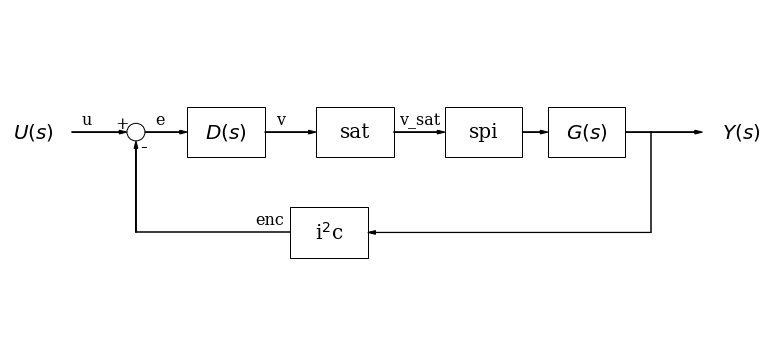

In [29]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
mysys.ax = ax
mysys.draw()
sum1.draw_input2_wire(ax)
plt.xlim([-1,25])
plt.ylim([-8,5])
mysys.axis_off()

In [30]:
i2c.outpur_dir

'left'

In [31]:
mysys.add_plot(['u','e','enc'],1,xlim=[0,1])
mysys.add_plot(['u','v','v_sat'],2,xlim=[0,1])

## i2c Block

- what should students need to do to create an i2c block to use in this kind of a system?
- what is needed to generate the correct python code?
    - `e, cur_resp = pi.i2c_read_device(m_ino,6)`
    - pigpio connection variable name and i2c connection variable name

## Codegen Test 

### Set execution order

`U` and `i2c` need to be executed first in the main loop: 

In [32]:
mysys.find_execution_order([U,i2c])

In [33]:
mysys.execution_order

In [34]:
mysys.generate_python_code("py_autogen_1.py",template_path="pylooptemplate.py")

In [35]:
mysys.python_file.list

['#import smbus',
 'import pigpio',
 'import time',
 'import numpy as np',
 'import copy',
 'import matplotlib.pyplot as plt',
 "plt.close('all')",
 'import py_block_diagram',
 'import serial_utils',
 '',
 '',
 'pi = pigpio.pi()',
 'if not pi.connected:',
 '    print("not connected")',
 '    exit()',
 '',
 '',
 '# leave this as manual for now',
 'TIMING_ADDRESS = 0x05',
 'MOTOR_ADDRESS = 0x04',
 '',
 '',
 't_ino = pi.i2c_open(1, TIMING_ADDRESS)',
 'm_ino = pi.i2c_open(1, MOTOR_ADDRESS)',
 'h_spi = pi.spi_open(0, 400000)',
 '',
 '#c, d = pi.i2c_read_device(h,8)',
 '',
 '',
 '',
 '',
 '# In[168]:',
 '',
 '# sysprecode',
 'N = 1000',
 'num_read = np.zeros(N)',
 'prev_check = -1',
 '',
 '',
 '# blockinitcode',
 'u_step_block = py_block_diagram.step_input(label="$U(s)$", on_time=0.1, amp=100)',
 'sum1_block = py_block_diagram.summing_junction()',
 'PD_block = py_block_diagram.PD_controller(label="$D(s)$", Kp=3, Kd=0.1)',
 'i2c_block_1 = py_block_diagram.i2c_read_block(i2c_connection=m_ino, 